In [70]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler

import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

import tensorflow as tf

In [71]:
print(os.listdir('/Users/victoriachu/Desktop/archive/data/'))

['.DS_Store', 'test', 'train']


In [72]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Training
training_dir = '/Users/victoriachu/Desktop/archive/data/train' 

train_datagen = ImageDataGenerator(rescale=1/255) 

train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=(224, 224),
    class_mode='binary'
)
print(train_generator.class_indices)

#Testing
testing_dir = '/Users/victoriachu/Desktop/archive/data/test'

test_datagen = ImageDataGenerator(rescale=1/255)

test_generator = test_datagen.flow_from_directory(
    testing_dir,
    target_size=(224, 224),
    class_mode='binary'
)
print(test_generator.class_indices)

Found 2637 images belonging to 2 classes.
{'benign': 0, 'malignant': 1}
Found 660 images belonging to 2 classes.
{'benign': 0, 'malignant': 1}


In [73]:
folder_benign_train = '/Users/victoriachu/Desktop/archive/data/train/benign'
folder_malignant_train = '/Users/victoriachu/Desktop/archive/data/train/malignant'

folder_benign_test = '/Users/victoriachu/Desktop/archive/data/test/benign'
folder_malignant_test = '/Users/victoriachu/Desktop/archive/data/test/malignant'

read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

# Load in training pictures 
ims_benign = [read(os.path.join(folder_benign_train, filename)) for filename in os.listdir(folder_benign_train)]
X_benign = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_train, filename)) for filename in os.listdir(folder_malignant_train)]
X_malignant = np.array(ims_malignant, dtype='uint8')

# Load in testing pictures
ims_benign = [read(os.path.join(folder_benign_test, filename)) for filename in os.listdir(folder_benign_test)]
X_benign_test = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_test, filename)) for filename in os.listdir(folder_malignant_test)]
X_malignant_test = np.array(ims_malignant, dtype='uint8')

# Create labels
y_benign = np.zeros(X_benign.shape[0])
y_malignant = np.ones(X_malignant.shape[0])

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])

# Merge data 
X_train = np.concatenate((X_benign, X_malignant), axis = 0)
y_train = np.concatenate((y_benign, y_malignant), axis = 0)

X_test = np.concatenate((X_benign_test, X_malignant_test), axis = 0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis = 0)

# Shuffle data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
y_train = y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
y_test = y_test[s]

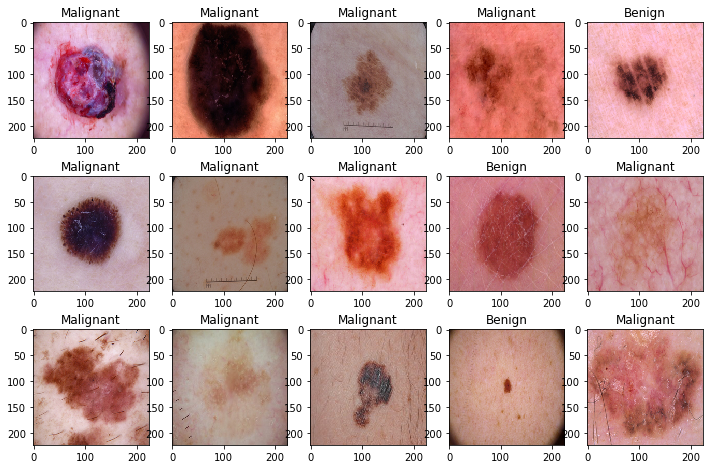

In [74]:
# Display first 15 images of moles, and how they are classified
w=40
h=30
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()

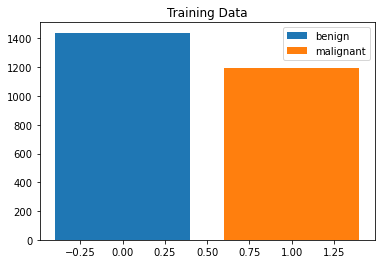

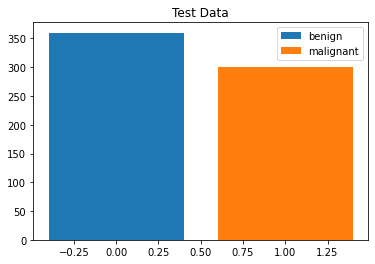

In [75]:
plt.bar(0, y_train[np.where(y_train == 0)].shape[0], label = 'benign')
plt.bar(1, y_train[np.where(y_train == 1)].shape[0], label = 'malignant')
plt.legend()
plt.title("Training Data")
plt.show()

plt.bar(0, y_test[np.where(y_test == 0)].shape[0], label = 'benign')
plt.bar(1, y_test[np.where(y_test == 1)].shape[0], label = 'malignant')
plt.legend()
plt.title("Test Data")
plt.show()


In [76]:
X_train = X_train/255
X_test = X_test/255
num_classes = 2 #no. of classes

train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes) #one hot encoding for the training set
test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes) #one hot encoding for the testing set

print(y_train[0])
print(train_one_hot[0])

train_size = X_train.shape[0]
test_size = X_test.shape[0]

print(f'Max pixel value: {X_train.max()}')
print(f'Min pixel value: {X_train.min()}')
print(f'Train size: {train_size}, Test size: {test_size}')
print(f'Train data shape: {X_train.shape}, Test data shape: {X_test.shape}')
print(f'Train label shape: {train_one_hot.shape}, Test label shape: {test_one_hot.shape}')

0.0
[1. 0.]
Max pixel value: 1.0
Min pixel value: 0.0
Train size: 2637, Test size: 660
Train data shape: (2637, 224, 224, 3), Test data shape: (660, 224, 224, 3)
Train label shape: (2637, 2), Test label shape: (660, 2)


In [77]:
#INPUT_SHAPE = [12*8]  #input shape for one image

#X_train = X_train.reshape([-1]+INPUT_SHAPE)
#X_test = X_test.reshape([-1]+INPUT_SHAPE)

#print(f'Train data shape: {X_train.shape}, Test data shape: {X_test.shape}')

In [79]:
from tensorflow.keras.layers import *
#You can change the architecture. This is just one from a book.
model = tf.keras.models.Sequential([
    #The parameters for Conv2D: Conv2D(number of covolutions, filter size, activation function, shape of image)
    Conv2D(16, (3,3), activation='relu' , input_shape=(224, 224, 3)),
    #This layer is required after each convolution. It basically highlights the important parts of it
    #The paramters for MaxPooling2D: MaxPooling2D(size of pooling). 2x2 means it halfs
    MaxPooling2D(2, 2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    #The flatten is used after all the Conv2D + MaxPooling2D. It basically squishes everything onto a one-dimentional array
    Flatten(),
    #This is the standard layer of neurons
    #The paramters for Dense: Dense(number of neurons, activation function)
    Dense(512, activation='relu'),
    #This is only 1 neuron because it's binary
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) #You can change the optimizer and loss

history = model.fit_generator(train_generator, epochs=25) #you can change the epochs (the amount of times it runs). Running it too much will cause overfitting though 
#It takes quite long per epoch as well since the model structure is quite deep.
model.summary()

/var/folders/46/76db0n9x52n72_mxlg5n_6y00000gn/T/ipykernel_69963/1936813318.py:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, epochs=25) #you can change the epochs (the amount of times it runs). Running it too much will cause overfitting though


Epoch 1/25
83/83 [==============================] - 39s 459ms/step - loss: 0.6226 - accuracy: 0.6348
Epoch 2/25
83/83 [==============================] - 39s 472ms/step - loss: 0.4911 - accuracy: 0.7588
Epoch 3/25
83/83 [==============================] - 38s 454ms/step - loss: 0.4347 - accuracy: 0.7884
Epoch 4/25
83/83 [==============================] - 38s 460ms/step - loss: 0.4128 - accuracy: 0.7880
Epoch 5/25
83/83 [==============================] - 38s 457ms/step - loss: 0.3859 - accuracy: 0.8100
Epoch 6/25
83/83 [==============================] - 38s 460ms/step - loss: 0.4050 - accuracy: 0.8024
Epoch 7/25
83/83 [==============================] - 38s 460ms/step - loss: 0.3702 - accuracy: 0.8153
Epoch 8/25
83/83 [==============================] - 38s 460ms/step - loss: 0.3588 - accuracy: 0.8225
Epoch 9/25
83/83 [==============================] - 38s 457ms/step - loss: 0.3943 - accuracy: 0.8256
Epoch 10/25
83/83 [==============================] - 38s 457ms/step - loss: 0.3362 - accura

In [80]:
#Testing the model
model.evaluate(test_generator)

21/21 [==============================] - 4s 153ms/step - loss: 0.8665 - accuracy: 0.8197


[0.86651211977005, 0.8196969628334045]

In [81]:
import tensorflow as tf
from tensorflow.keras.layers import *

In [82]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate = 0.001,
    beta_1 = 0.9,
    beta_2 = 0.999,
    epsilon=1e-7,
    name='Adam'
)

model.compile(
    loss = 'categorical_crossentropy',
    optimizer = optimizer,
    metrics=['accuracy']
)

<AxesSubplot:>

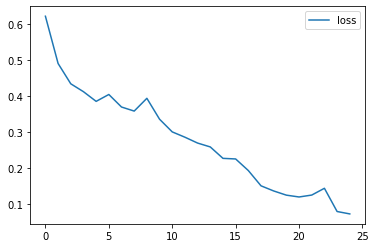

In [83]:
res = pd.DataFrame(history.history)
res[['loss']].plot()

<AxesSubplot:>

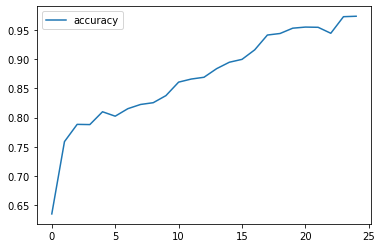

In [84]:
res[['accuracy']].plot()

In [85]:
prediction = model.predict(X_test) #calling model.predict() here


print(
    f'sum: {np.sum(prediction, axis=1)}\n'
    f'predict index: {np.argmax(prediction, axis=1)}'
)


sum: [8.94618495e-07 1.00000000e+00 4.91883755e-02 9.84698415e-01
 1.00000000e+00 3.80307436e-04 2.14062512e-01 2.89182901e-01
 9.93319750e-01 9.99107361e-01 4.56252856e-05 6.54159129e-01
 8.83603036e-01 5.00792848e-05 9.99927938e-01 4.15945351e-01
 1.12572059e-04 9.44795549e-01 1.00000000e+00 1.30956391e-06
 1.16744930e-04 5.46368480e-01 7.11911998e-05 1.89459324e-02
 6.63730323e-01 5.62787414e-01 1.00000000e+00 1.33973231e-06
 1.42558813e-01 5.14258281e-05 6.03347838e-01 1.00000000e+00
 1.44135952e-03 2.16265335e-07 1.37346447e-07 3.20264697e-03
 8.18607211e-03 2.26346492e-05 2.69991159e-03 5.59031963e-03
 1.15901776e-05 8.98957253e-04 9.96456027e-01 8.59137058e-01
 9.99546170e-01 1.48638060e-06 1.00000000e+00 1.00000000e+00
 4.27911878e-02 9.99952912e-01 2.80144811e-03 9.99736011e-01
 1.59263611e-04 9.26829875e-01 2.97738373e-01 9.61030483e-01
 1.32619598e-05 9.99791443e-01 1.83313787e-02 9.98702407e-01
 1.00000000e+00 4.40980657e-05 3.55240762e-01 8.16792250e-04
 9.99894738e-01 9.9

In [86]:
prediction

array([[8.94618495e-07],
       [1.00000000e+00],
       [4.91883755e-02],
       [9.84698415e-01],
       [1.00000000e+00],
       [3.80307436e-04],
       [2.14062512e-01],
       [2.89182901e-01],
       [9.93319750e-01],
       [9.99107361e-01],
       [4.56252856e-05],
       [6.54159129e-01],
       [8.83603036e-01],
       [5.00792848e-05],
       [9.99927938e-01],
       [4.15945351e-01],
       [1.12572059e-04],
       [9.44795549e-01],
       [1.00000000e+00],
       [1.30956391e-06],
       [1.16744930e-04],
       [5.46368480e-01],
       [7.11911998e-05],
       [1.89459324e-02],
       [6.63730323e-01],
       [5.62787414e-01],
       [1.00000000e+00],
       [1.33973231e-06],
       [1.42558813e-01],
       [5.14258281e-05],
       [6.03347838e-01],
       [1.00000000e+00],
       [1.44135952e-03],
       [2.16265335e-07],
       [1.37346447e-07],
       [3.20264697e-03],
       [8.18607211e-03],
       [2.26346492e-05],
       [2.69991159e-03],
       [5.59031963e-03],


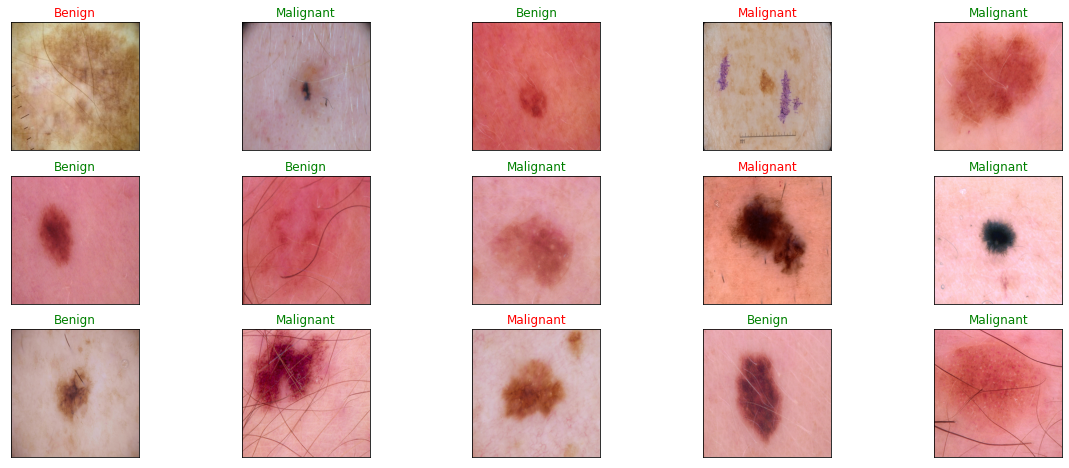

In [93]:
figure = plt.figure(figsize=(20,8))

for i, index in enumerate(np.random.choice(X_test.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
   
    ax.imshow(X_test[index].reshape(224,224,3), cmap='gray')
    predict_index = np.argmax(prediction[index])
    true_index = np.argmax(test_one_hot[index])
   
    ax.set_title("{} ({})".format(y_test[predict_index], 
                y_test[true_index]),
                color=("green" if predict_index == true_index else "red"))
    
    if y_test[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    